In [2]:
from __future__ import print_function

import pyKriging
from pyKriging.krige import kriging
from pyKriging.samplingplan import samplingplan

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
import pylab

from nltrans import Transformation
import zimg  

#####################################################
#####################################################

[[0.707, -0.5, 0.3, -100], [0.5, 0.707, 0.3, -100]]
[0.001, 0.001, 2, 2]
[0.01, 0.01, 2, 2]
Now plotting final results of k1...


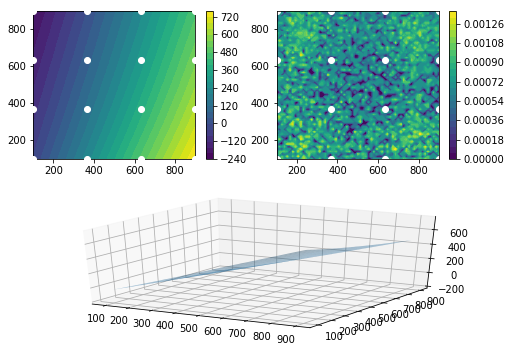

[0.001, 0.001, 2, 2]
[0.01, 0.01, 2, 2]
Now plotting final results of k2...


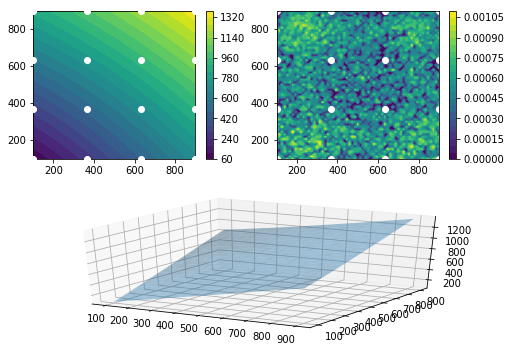

rms of linear fit: 19.31
rms of nonlinear fit: 0.00


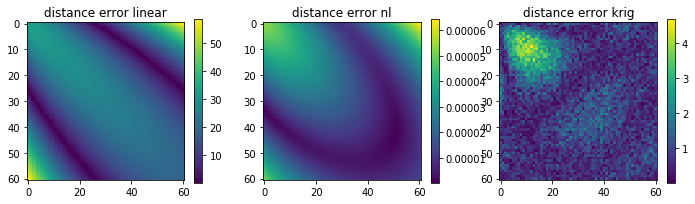

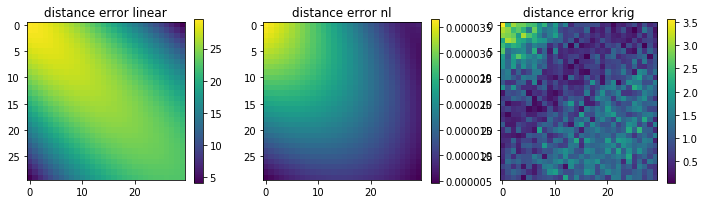

In [5]:
# generate points from different coord systems (trans1.applytrans)
number_of_point = 4
size_of_img = 1000
noise_percentage = 0
noise = (np.random.rand(number_of_point* number_of_point,2) - 0.5) * (size_of_img * noise_percentage)

points_1 = np.linspace(size_of_img * 0.1, size_of_img * 0.9, num=number_of_point)
points_1 = np.meshgrid(points_1, points_1)
points_1 = np.reshape(np.ravel(points_1), (2, number_of_point ** 2)).T

# trans1 = Transformation('linear', points_1)
# ideal_trans = [[1.2, -0.1, -100], [0, 1, -100]]

trans1 = Transformation('nonlinear', points_1)
ideal_trans = [[0.707, -0.5, 0.3, -100], [0.5, 0.707, 0.3, -100]]
print(ideal_trans)

points_2_ideal = trans1.applytrans(ideal_trans)
points_2_with_noise = points_2_ideal + noise
trans1.data2=points_2_with_noise

############################################################
# fit and apply linear and non-linear transform
(calib_lin, err_lin) = trans1.fit_trans('linear')
points_2_lin = trans1.applytrans(calib_lin)

(calib_nl, err_nl) = trans1.fit_trans('nonlinear')
points_2_nl = trans1.applytrans(calib_nl)

####################################
# kriging
k1 = kriging(points_1, points_2_with_noise[:, 0], name='simple', testPoints=25)
k1.train(optimizer='ga')
k1.snapshot()
print('Now plotting final results of k1...')
X, Y, kx = k1.plot()
######
k2 = kriging(points_1, points_2_with_noise[:, 1], name='simple', testPoints=25)
k2.train(optimizer='ga')
k2.snapshot()
print('Now plotting final results of k2...')
X, Y, ky = k2.plot()
####################################
# overlay the original and transformed coordinates

def rms(data1, data2):
    return ((np.asarray(data1) - np.asarray(data2)) ** 2).mean() ** .5
    
print('rms of linear fit: ' + str("%.2f" % rms(points_2_lin, points_2_ideal)))
print('rms of nonlinear fit: ' + str("%.2f" % rms(points_2_nl, points_2_ideal)))
plt.title('number_of_point= ' + str(number_of_point ** 2))
plt.scatter(points_1[:, 0], points_1[:, 1], color='red')
plt.scatter(points_2_with_noise[:, 0], points_2_with_noise[:, 1], color='blue')
plt.scatter(points_2_lin[:, 0], points_2_lin[:, 1], color='green')
plt.scatter(points_2_nl[:, 0], points_2_nl[:, 1], color='orange')
plt.scatter(points_2_ideal[:, 0], points_2_ideal[:, 1], color='purple')
# plt.scatter(kx, ky, color='black')
plt.legend(
    ['data1', 'data2_with_noise', 'fitting_linear', 'fitting_nonlinear', 'data2_ideal (without_noise)', 'Kriging'])
plt.show()
####################################
# apply transform with [61,61] points to 3 different methods
# then show the rms as image

XY = np.dstack((X, Y))
XY = np.reshape(XY, (-1, 2))

trans1.type_of_trans='nonlinear'
idealXY = trans1.applytrans(ideal_trans,XY)
trans1.type_of_trans='linear'
linearXY = trans1.applytrans(calib_lin, XY)
trans1.type_of_trans='nonlinear'
nlXY = trans1.applytrans(calib_nl, XY)
krigXY = np.dstack((kx, ky))
krigXY = np.reshape(krigXY, (-1, 2))

rms_linear = np.array(((linearXY[:, 0] - idealXY[:, 0]) ** 2 + (linearXY[:, 1] - idealXY[:, 1]) ** 2) ** 0.5)
rms_nl = np.array(((nlXY[:, 0] - idealXY[:, 0]) ** 2 + (nlXY[:, 1] - idealXY[:, 1]) ** 2) ** 0.5)
rms_krig = np.array(((krigXY[:, 0] - idealXY[:, 0]) ** 2 + (krigXY[:, 1] - idealXY[:, 1]) ** 2) ** 0.5)

rms_linear = np.reshape(rms_linear, (61, 61))
rms_nl = np.reshape(rms_nl, (61, 61))
rms_krig = np.reshape(rms_krig, (61, 61))

fig = pylab.figure(figsize=(12, 3))
fig.add_subplot(131)
plt.imshow(rms_linear)
plt.title('distance error linear')
# pylab.contourf(X, Y, rms_linear, 25)
pylab.colorbar()
fig.add_subplot(132)
plt.imshow(rms_nl)
plt.title('distance error nl')
# pylab.contourf(X, Y, rms_nl, 25)
pylab.colorbar()
fig.add_subplot(133)
plt.imshow(rms_krig)
plt.title('distance error krig')
# pylab.contourf(X, Y, rms_krig, 25)
pylab.colorbar()
plt.show()

fig = pylab.figure(figsize=(12, 3))
fig.add_subplot(131)
plt.imshow(rms_linear[15:45,15:45])
plt.title('distance error linear')
# pylab.contourf(X, Y, rms_linear, 25)
pylab.colorbar()
fig.add_subplot(132)
plt.imshow(rms_nl[15:45,15:45])
plt.title('distance error nl')
# pylab.contourf(X, Y, rms_nl, 25)
pylab.colorbar()
fig.add_subplot(133)
plt.imshow(rms_krig[15:45,15:45])
plt.title('distance error krig')
# pylab.contourf(X, Y, rms_krig, 25)
pylab.colorbar()
plt.show()


1.1279593373070353
